# Project Group 29

The final report will be a written report that clearly communicates the information below, in a manner suitable for the general audience who might or might not have taken a time series class.
● A description of the methods you have chosen for this project. A textual and/or visual justification of why you chose these methods is required (i.e. what type of model did you choose, why, and how did you choose it).
● A textual and/or visual report on your findings.
● A graphical and tabular forecasting results that must include the ​RMSE​ ​of the forecasting
of the Jan-Dec 2016.
In addition to the report, you must submit a ​Jupyter notebook ​containing all your codes. Each group will submit one report and notebook.

In [433]:
#upload the libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import datetime 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [440]:
#upload the data
series = pd.read_csv('zillow-carlifornia.csv',header=0, index_col="Date", parse_dates=True,
squeeze=True)
series.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


In [441]:
#Change the column names
series=series.rename(columns={"Date": "ds","MedianSoldPrice_AllHomes.California":"Sold_Price", "MedianMortageRate":"Mortage_Rate", "UnemploymentRate":"Unemployment_Rate"})
series.head()

,Sold_Price,Mortage_Rate,Unemployment_Rate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


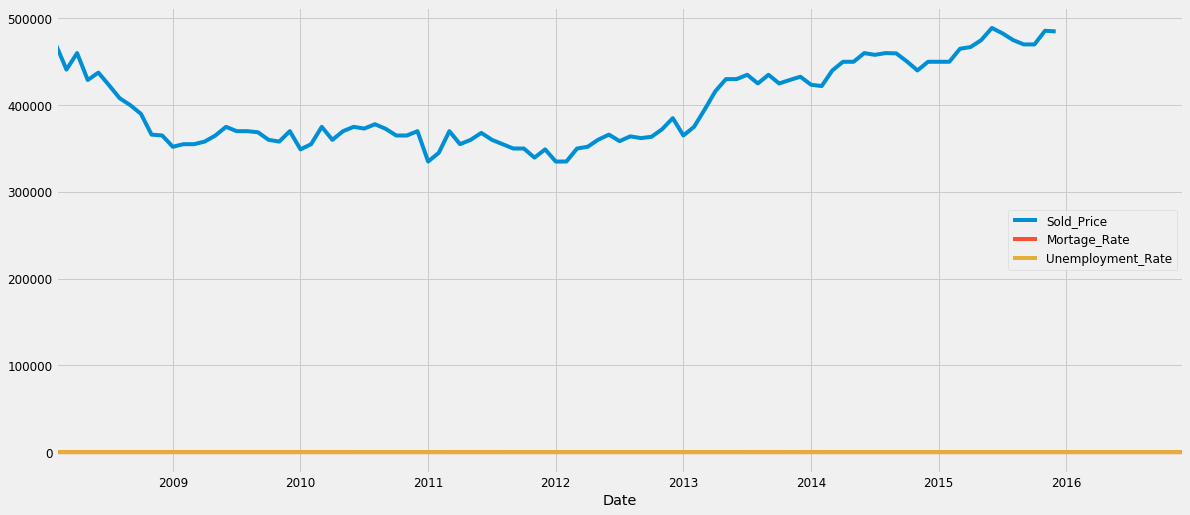

In [442]:
#Plot the original TS
series.plot()
plt.show()

In [443]:
series.isnull().sum()

Sold_Price           12
Mortage_Rate          0
Unemployment_Rate     0
dtype: int64

In [445]:
series=series.dropna()

In [446]:
series.tail()

,Sold_Price,Mortage_Rate,Unemployment_Rate
Date,,,
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1


In [447]:
#Correlation between price and unemployment rate and mortage rate
#Correlation between price and mortage rate -> - 0.00839711. Not a significant negative correlation: if mortage rate goes down, the price goes up.
r1 = np.corrcoef(series.Sold_Price,series.Mortage_Rate)
r1

array([[ 1.        , -0.00839711],
       [-0.00839711,  1.        ]])

In [448]:
#Correlation between price and unemployment rate
r2 = np.corrcoef(series.Sold_Price,series.Unemployment_Rate)
r2

array([[ 1.        , -0.64630235],
       [-0.64630235,  1.        ]])

In [449]:
#One-variable analysis
y = series['Sold_Price']

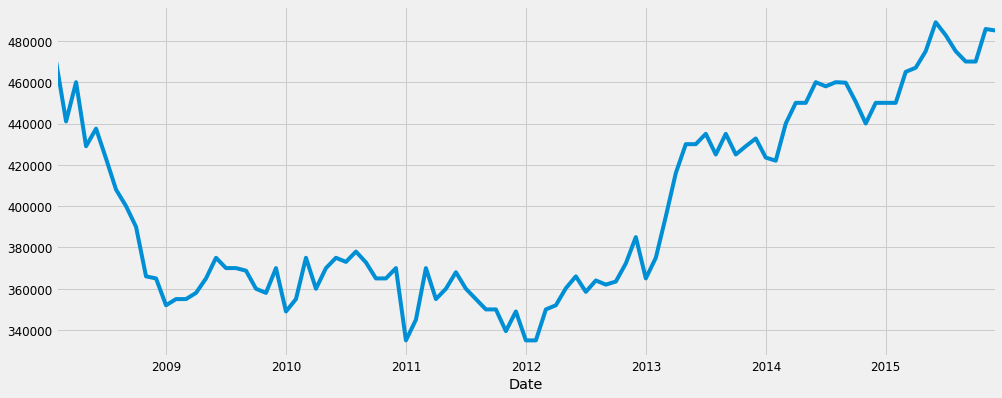

In [450]:
y.plot(figsize=(15, 6))
plt.show()

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

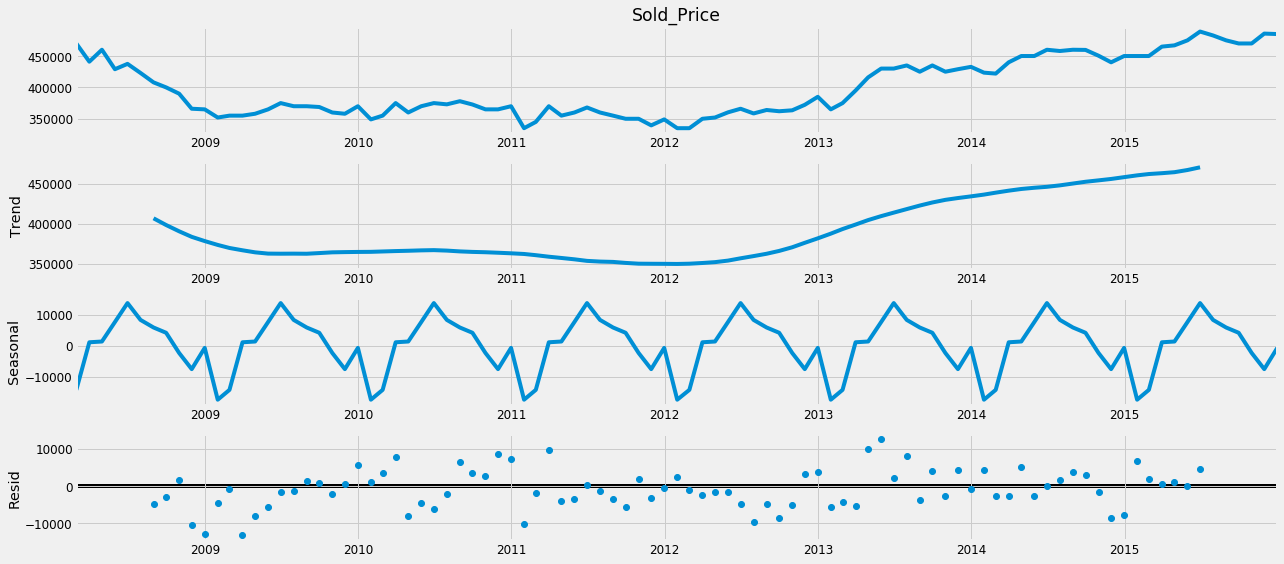

In [451]:
#Additive
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

We have seasonality and trend here.

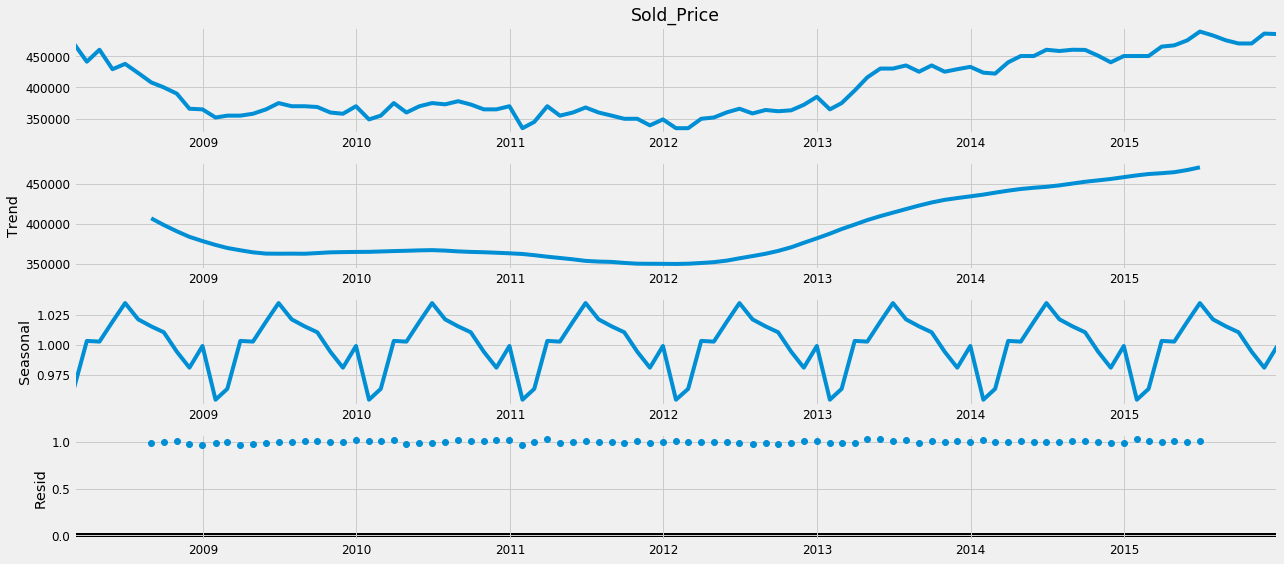

In [452]:
#Multiplictive
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

Autocorrelation helps us study how each time series observation is related to its recent (or not so recent) past. It is easy to get that tomorrow’s house price is very likely to be related to today’s house price. ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) are two powerful tools. ACF represents autocorrelation of a time series as a function of the time lag. PACF seeks to remove the indirect correlations that exist in the autocorrelation for an observation and an observation at a prior time step.m

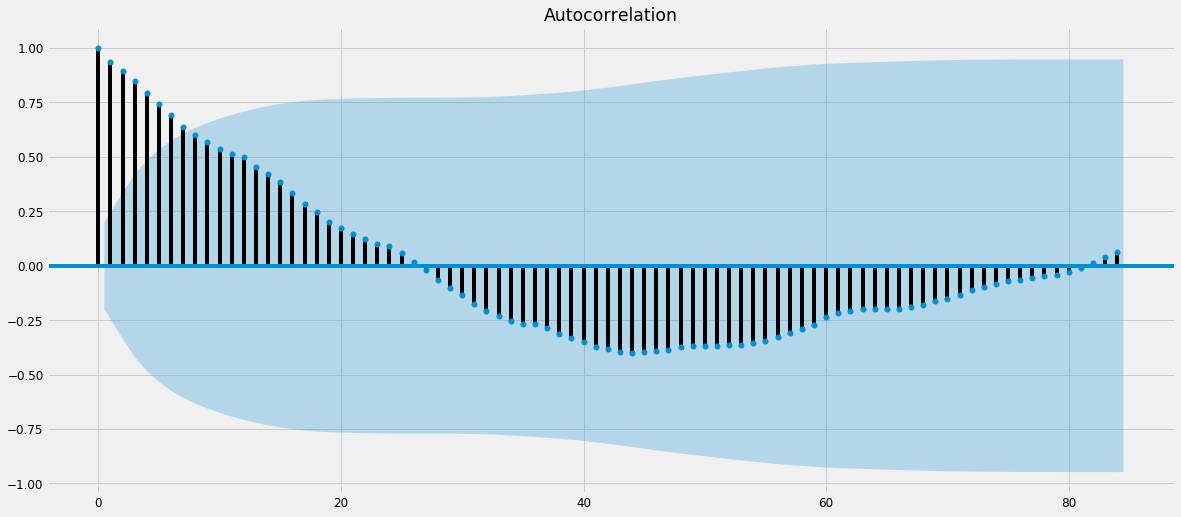

In [392]:
#ACF plot
plot_acf(y, lags=84)
plt.show()

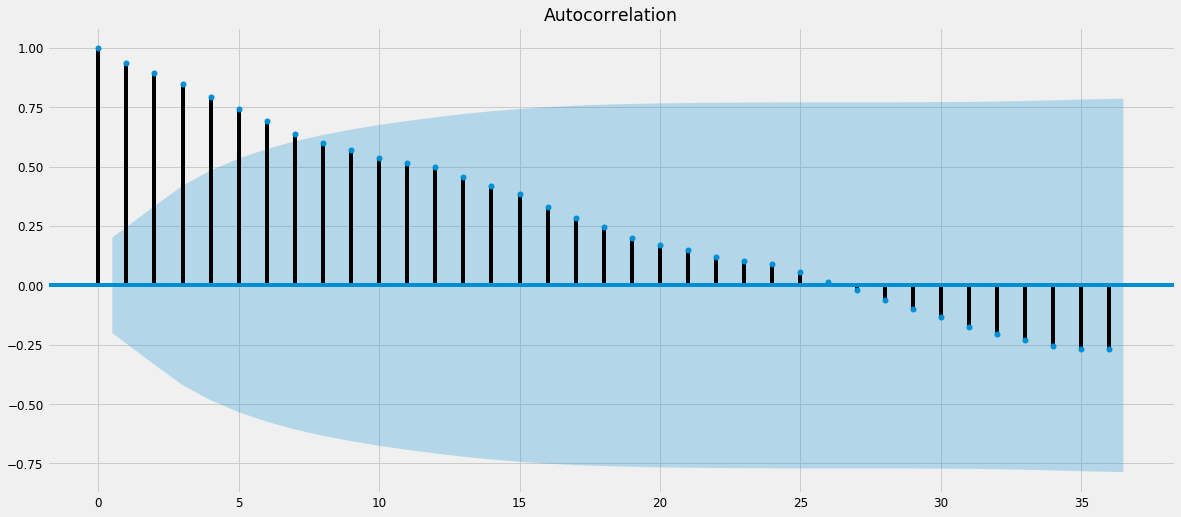

In [393]:
#3 years ACF
plot_acf(y, lags=36)
plt.show()

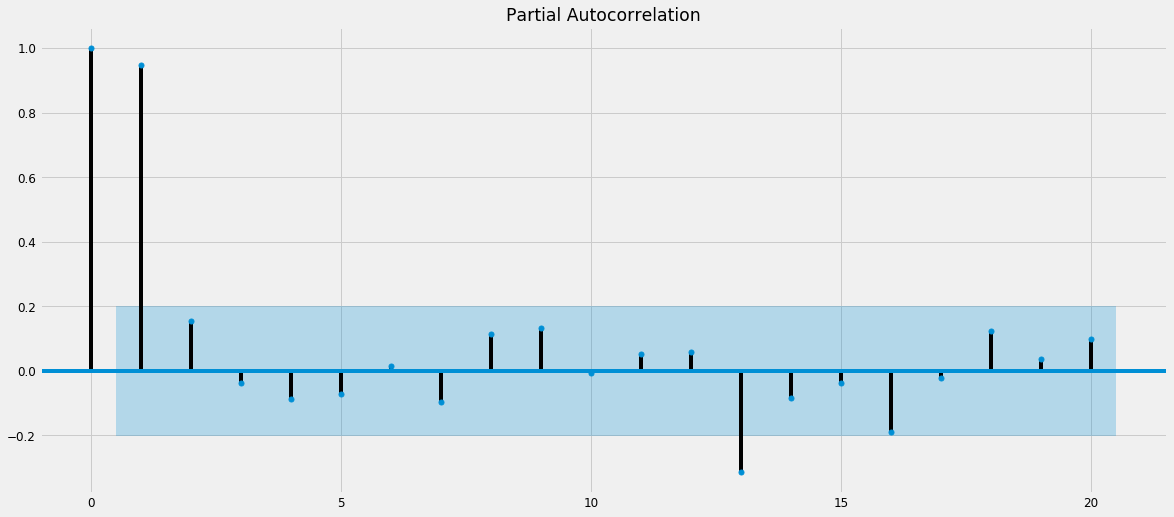

In [278]:
#PACF plot
plot_pacf(y,lags=20)
plt.show()

Dickey-Fuller test can be used to test if a time series is stationary or not. 

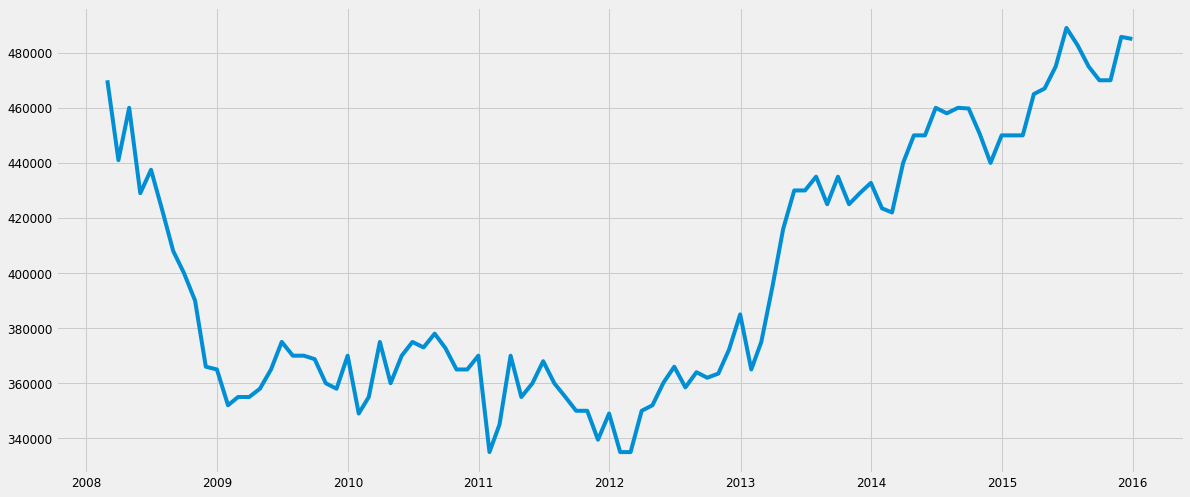

In [394]:
plt.plot(y)

In [453]:
from statsmodels.tsa.stattools import adfuller

X = y.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.058792
p-value: 0.953391
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


Conclusion from the test: We can see that ADF statistics is larger than the critical values, meaning that we can fail to reject the null hypothesis and in turn that the time series is non-stationary.

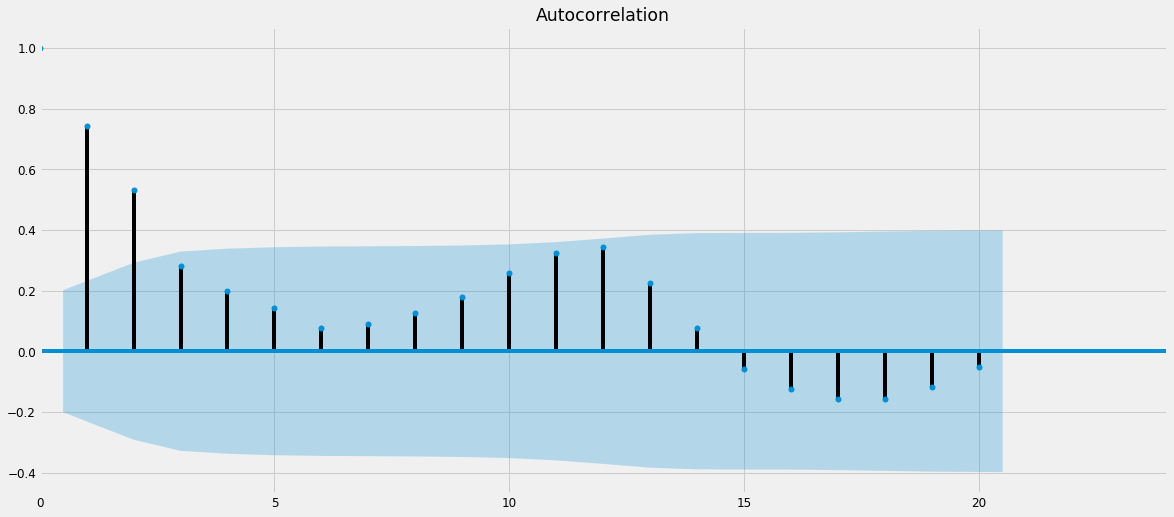

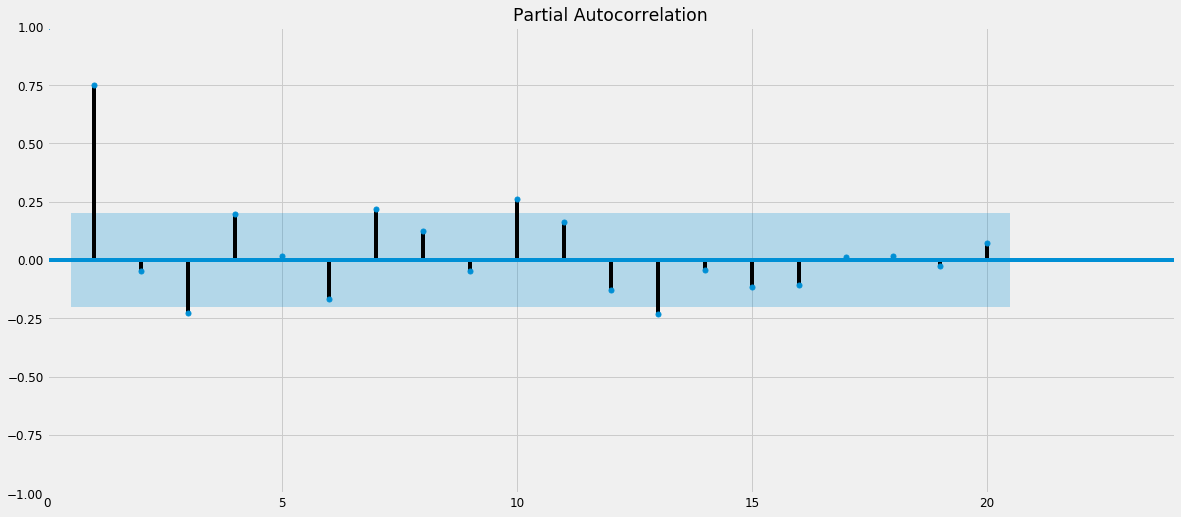

In [396]:
plot_acf(y.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(y.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

# Price Prediction using Prophet

Why Prophet: one of the most flexible models, works great with monthly data with seasonality and trend. Also, capture the historic pattern of the data and reproduce it in the prediction. Has a decent prediction power.

In [241]:
# evaluate prophet time series forecasting model on hold out dataset
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

In [242]:
#upload the data
history = pd.read_csv('zillow-carlifornia.csv')
dt=history[['Date','MedianSoldPrice_AllHomes.California']]
dt=dt.rename(columns={"Date": "ds","MedianSoldPrice_AllHomes.California":"y"})

In [244]:
dt.head()

,ds,y
0,2008-02-29,470000.0
1,2008-03-31,441000.0
2,2008-04-30,460000.0
3,2008-05-31,429000.0
4,2008-06-30,437500.0


In [245]:
dt=dt.dropna()

In [246]:
dt.dtypes

ds     object
y     float64
dtype: object

In [247]:
dt.tail()

,ds,y
90,2015-08-31,475000.0
91,2015-09-30,470000.0
92,2015-10-31,470000.0
93,2015-11-30,485750.0
94,2015-12-31,485000.0


In [337]:
#Train the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.fit(dt)

#Make some predictions
future = m.make_future_dataframe(periods=12, freq = "m", include_history = False)
forecast = m.predict(future)
forecast.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-31,487203.494579,455448.132733,478454.448993,486677.661066,487999.154072,-0.042387,-0.042387,-0.042387,-0.042387,-0.042387,-0.042387,0.0,0.0,0.0,466552.383120
1,2016-02-29,489142.751534,470779.828637,494022.667016,487378.544912,491591.214568,-0.013605,-0.013605,-0.013605,-0.013605,-0.013605,-0.013605,0.0,0.0,0.0,482487.848733
2,2016-03-31,491215.750348,469491.222905,493643.736778,488184.195155,495751.080909,-0.020659,-0.020659,-0.020659,-0.020659,-0.020659,-0.020659,0.0,0.0,0.0,481067.532823
3,2016-04-30,493221.878233,489784.738182,514460.900088,488669.337892,499667.634435,0.018015,0.018015,0.018015,0.018015,0.018015,0.018015,0.0,0.0,0.0,502107.282550
4,2016-05-31,495294.877047,486484.221276,513769.196250,489022.502373,504661.479661,0.008760,0.008760,0.008760,0.008760,0.008760,0.008760,0.0,0.0,0.0,499633.827645


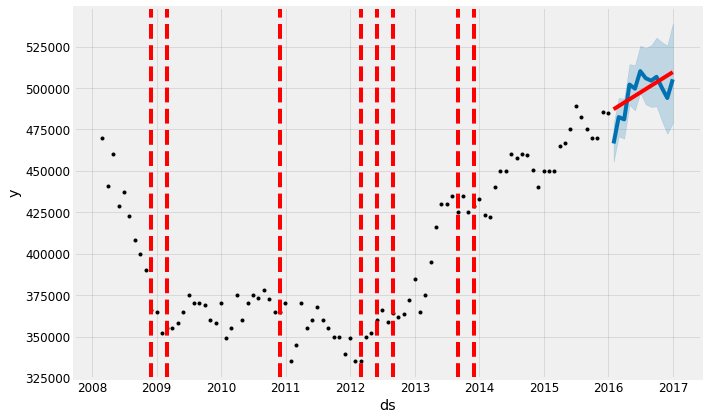

In [338]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


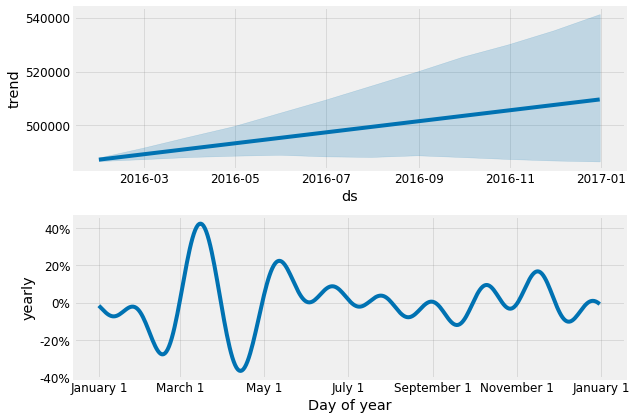

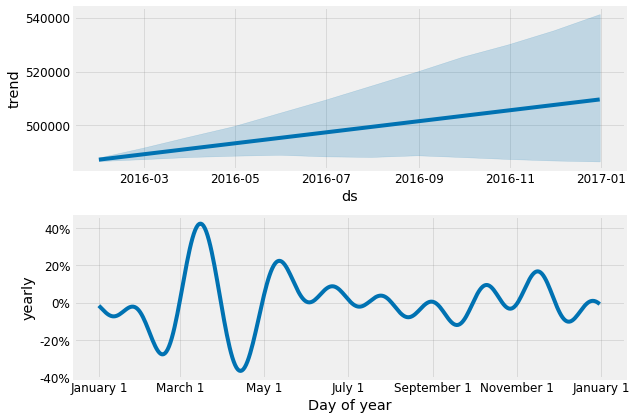

In [339]:
m.plot_components(forecast)

In [340]:
prediction = forecast[["ds","yhat"]]
actual = pd.read_csv("test.csv")

In [341]:
actual.dtypes

Month                 object
Median House Price     int64
dtype: object

In [342]:
y_true = actual["Median House Price"]
y_pred = prediction["yhat"]

In [355]:
#MSE
MSE = mean_squared_error(y_true, y_pred)
print(MSE)

95682341.39106478


In [359]:
#RMSE
RMSE = sqrt(MSE)
print(RMSE)

9781.73509102883


In [358]:
#coefficient of determination
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

#shows how model fits the observed data. Not a brilliant result, unfortunatly.

0.6021603243954623

The forecasted values tend to be 9782 orders different on average compared to what the real values would be.

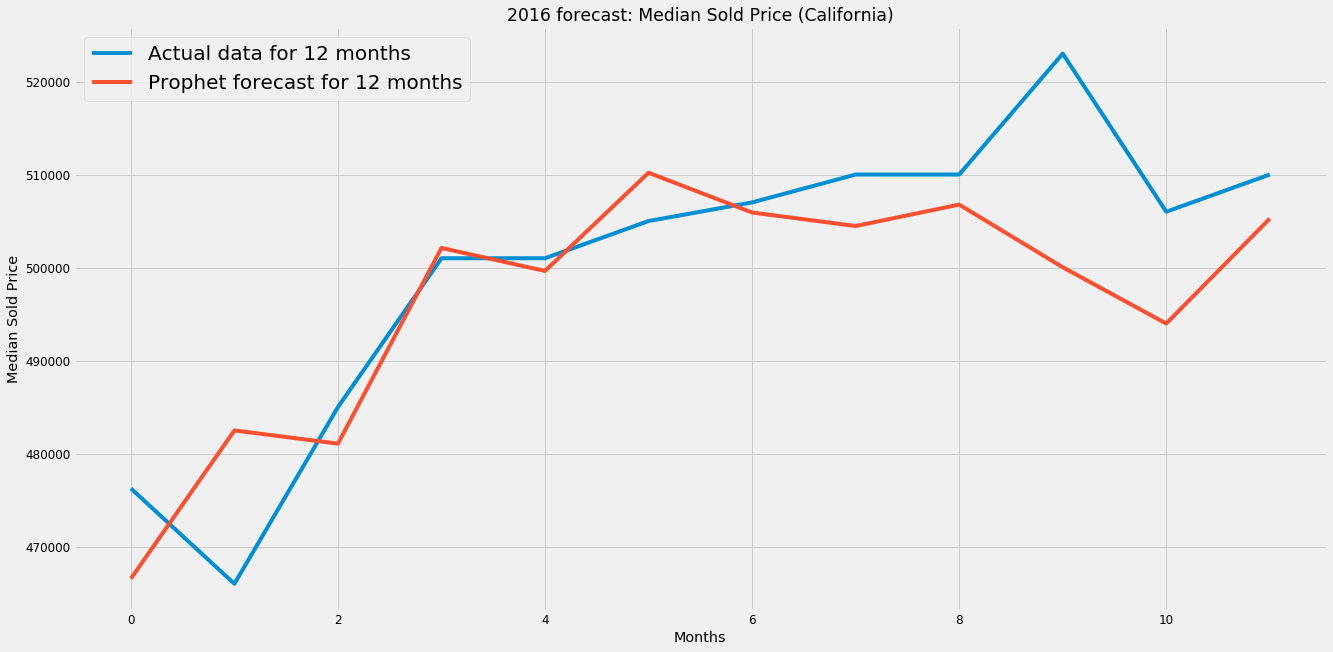

In [352]:
#Plot the prediction vs actual
plt.figure(figsize=(20, 10))
plt.plot(y_true, label='Actual data for 12 months')
plt.plot(y_pred, label='Prophet forecast for 12 months')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('Months')
plt.ylabel('Median Sold Price')
plt.title('2016 forecast: Median Sold Price (California)')
plt.show()

In [351]:
#MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true, y_pred)

1.4614616981679576

In [ ]:
MSE: 95682341.39106478
RMSE: 9781.73509102883
MAPE: 1.4614616981679576 